In [30]:
# Googleドライブへのマウント（Colab用コード）
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/ou_dip/sample.jpg/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/ou_dip/sample.jpg


In [31]:
import cv2
import numpy as np  # PythonのOpenCVでは、画像はnumpyのarrayとして管理される
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  plt.figure(figsize = (img.shape[1]/100.0,img.shape[0]/100.0))
  if img.ndim == 3:
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
  elif img.ndim == 2:
    plt.imshow(img, cmap = "gray")
  else:
    plt.imshow(img)

In [32]:
# 先週のコードと異なり、周波数領域でのエイリアシングを防ぐために画像と同サイズの空間フィルタを作るようにした

def createSpatialGaussian(sigma, img):
  # sigma: 標準偏差, img: 入力画像
  gauss_1d = cv2.getGaussianKernel(img.shape[0], sigma)
  gauss_2d = np.matmul(gauss_1d, gauss_1d.T)
  return gauss_2d

def createFrequencyGaussian(spatial_filter, img):
  # 空間フィルタをDFTして周波数フィルタを生成（他の方法もあるが、実装が楽なので）
  # spatial_filter: 空間フィルタ, img: 入力画像

  spatial_filter_lt = np.fft.ifftshift(spatial_filter) # 左上原点に変更
  gauss_freq = np.fft.fft2(spatial_filter_lt) # numpyの複素数

  # 可視化用
  gauss_absolute = np.absolute(gauss_freq)

  return gauss_freq, gauss_absolute

Frequency filter:


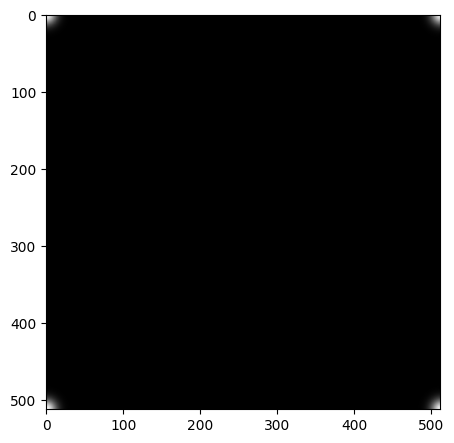

In [33]:
# 準備：画像の読み込みとフィルタの生成
sigma = 9 # 対応する空間ガウシアンフィルタのsigma

src = cv2.imread("sample.jpg", cv2.IMREAD_GRAYSCALE) # 画像読み込み

print('Frequency filter:')
spatial_filter = createSpatialGaussian(sigma, src)
freq_filter, freq_absolute = createFrequencyGaussian(spatial_filter, src)  # 左上原点！
imshow(freq_absolute  * 255) # 最大値が255になるようにして表示

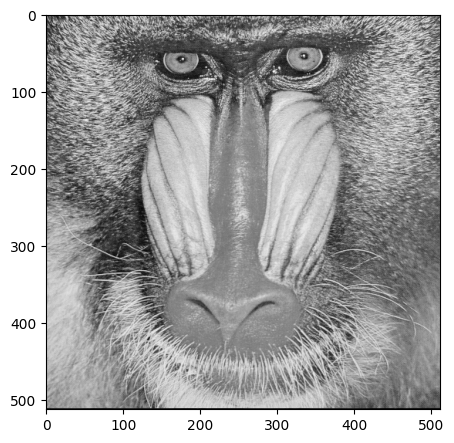

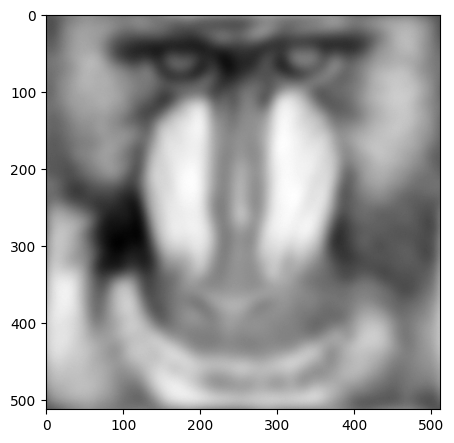

In [34]:
# 周波数フィルタによる画像劣化

# 画像をぼかす
src_freq = np.fft.fft2(src) # numpyの複素数
blurred_freq = src_freq * freq_filter
blurred = np.fft.ifft2(blurred_freq).real # 実部をとってくる

# 微小なノイズを付加する（正規分布 sigma=0.5）
noise = np.random.normal(0.0, 0.5, blurred.shape)
blurred = blurred + noise # ここをコメントアウトすると、逆フィルタでもきれいに復元できるが。。。？

imshow(src)
imshow(blurred)

In [ ]:
# 逆フィルタによる画像復元
# 劣化画像: blurred, 点拡がり関数のフーリエ変換H: freq_filter

# inverse filter
inv_filter = np.reciprocal(freq_filter+0.0000000001) # 複素数の逆数。0割り算を防ぐために微小な数を加算
#imshow((np.abs(inv_filter)-1.0) * 255) # 逆フィルタを可視化したいとき

# inverse filterの適用
blurred_freq = np.fft.fft2(blurred)
deblur_freq = blurred_freq * inv_filter
deblur = np.fft.ifft2(deblur_freq).real # 逆フーリエ変換

# 表示
print("reconstructed image")
imshow(deblur)

reconstructed image


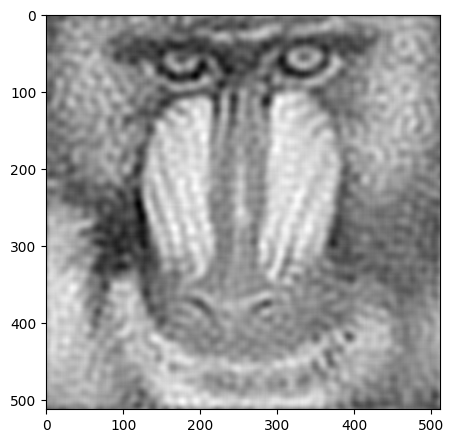

In [48]:
# ウィーナフィルタによる画像復元
# 劣化画像: blurred, 点拡がり関数のフーリエ変換H: freq_filter

# wiener filter（ここを作成）
gamma = 0.00001
wiener_filter = np.conjugate(freq_filter) / (np.abs(freq_filter) ** 2 + gamma)

# wiener filterの適用
blurred_freq = np.fft.fft2(blurred)
deblur_freq = blurred_freq * wiener_filter
deblur = np.fft.ifft2(deblur_freq).real

# 表示
print("reconstructed image")
imshow(deblur)